In [2]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

api = wandb.Api(timeout=60)
runs = [run for run in api.sweep('concat_moons/' + 'i9ddjy2w').runs]
runs += [run for run in api.sweep('concat_moons/' + 'ui53he8j').runs]
runs += [run for run in api.sweep('concat_moons/' + 'tqrtw8se').runs]
runs += [run for run in api.sweep('concat_moons/' + 'aoerq0e0').runs]

histories = [run.history() for run in runs]
configs = [run.config for run in runs]

In this notebook, the graph for comparing the influence of the number of pruning levels versus the size of the network.

yayo
yayo
yayo
yayo
yayo
yayo
yayo
yayo
yayo
yayo
yayo
yayo


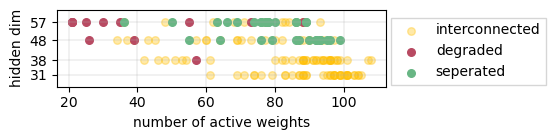

In [25]:
split, degrade, levels, split_degrade, connected = [], [], [], [], []
for h, c in zip(histories, configs):
    potential = h['graph/untapped-potential'].values
    indices_split = list(np.where(potential == 0)[0])
    indices_degraded = list(np.where(potential < 0)[0])

    y = list(h['graph/active-weights-abs'])[-1]
    x = c['model_shape'][1]
    x, y = y, x
    levels.append(c['pruning_levels'])
    if indices_split and not indices_degraded:
        split.append((x,y))
    elif indices_degraded and not indices_split:
        print('yayo')
        degrade.append((x,y))
    elif indices_degraded and indices_split:
        print('DEGSPL')
        split_degrade.append((x,y))
    elif not indices_degraded and not indices_split:
        connected.append((x,y))

alpha=1
marker='o'
size=30
plt.figure(figsize=(6,1.5))
plt.grid(linewidth = 0.25)

if split_degrade: plt.scatter(*zip(*split_degrade), color='#508B65', label='seperated-degraded', alpha=alpha, marker=marker,  s=size)
plt.scatter(*zip(*connected), color='#FFC107', label='interconnected', alpha=0.35, marker=marker,  s=size)
plt.scatter(*zip(*degrade), color='#B84A62', label='degraded', alpha=alpha, marker=marker,  s=size)
plt.scatter(*zip(*split), color='#68B684', label='seperated', alpha=alpha, marker=marker,  s=size)
plt.ylabel('hidden dim')
plt.xlabel('number of active weights')
plt.legend(loc='upper center', fancybox=False, ncol=1, bbox_to_anchor=(1.25, .99))
plt.yticks((31,38,48,57))
plt.ylim((25, 63))
plt.tight_layout()
plt.savefig('grid-eval-abs.png', bbox_inches='tight')

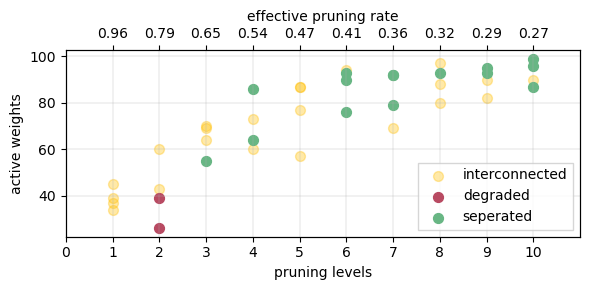

In [27]:
split, degrade, levels, split_degrade, connected = [], [], [], [], []
prs = set()
hd=48
for h, c in zip(histories, configs):

    if c['model_shape'][1] not in [hd]: continue
    x, t = [], c['param_trajectory']
    for i in range(len(t)-1):
        x.append(1 - (t[i+1] / t[i]))
    pr = np.mean(x)

    potential = h['graph/untapped-potential'].values
    indices_split = list(np.where(potential == 0)[0])
    indices_degraded = list(np.where(potential < 0)[0])

    x = c['pruning_levels']
    x = list(h['graph/active-weights-abs'])[-1]
    prs.add(round(pr, 2))
    y = c['pruning_levels']
    x, y = y, x
    levels.append(c['pruning_levels'])
    if indices_split and not indices_degraded:
        split.append((x,y))
    elif indices_degraded and not indices_split:
        degrade.append((x,y))
    elif indices_degraded and indices_split:
        split_degrade.append((x,y))
    elif not indices_degraded and not indices_split:
        connected.append((x,y))
alpha=1
marker='o'
size=50
plt.figure(figsize=(6,3))
plt.grid(linewidth = 0.25)
plt.ylabel('active weights')
plt.xlabel('pruning levels')
plt.xticks(range(11))
plt.xlim((0,11))
if split_degrade: plt.scatter(*zip(*split_degrade), color='#508B65', label='seperated-degraded', alpha=alpha, marker=marker,  s=size)
if connected: plt.scatter(*zip(*connected), color='#FFC107', label='interconnected', alpha=0.35, marker=marker,  s=size)
if degrade : plt.scatter(*zip(*degrade), color='#B84A62', label='degraded', alpha=alpha, marker=marker,  s=size)
if split: plt.scatter(*zip(*split), color='#68B684', label='seperated', alpha=alpha, marker=marker,  s=size)
plt.legend(loc='lower right', fancybox=False, ncol=1)
xaxis = plt.twiny()
xaxis.set_xticks(range(1,11),list(reversed(sorted(list(prs)))))
plt.xlim((0,11))
plt.ylabel('active weights')
plt.xlabel('effective pruning rate')
plt.tight_layout()
plt.savefig(f'grid-pruning-rate-{hd}-hd.png', bbox_inches='tight')

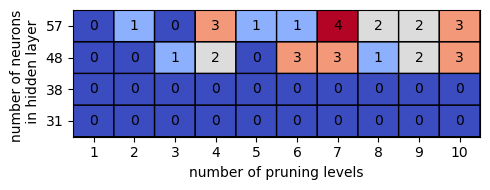

In [111]:
df_split = pd.DataFrame(np.zeros((10, 4)), columns=[31, 38, 48, 57], index=[1,2,3,4,5,6,7,8,9,10])
df_degrade = pd.DataFrame(np.zeros((10, 4)), columns=[31, 38, 48, 57], index=[1,2,3,4,5,6,7,8,9,10])

for r, h, c in zip(runs, histories, configs):
    split = (h['graph/untapped-potential'] == 0).any()
    degraded = (h['graph/untapped-potential'] < 0).any()
    hidden_dim = c['model_shape'][1]
    levels = c['pruning_levels']
    df_split[hidden_dim][levels] += 1 if split else 0
    df_degrade[hidden_dim][levels] += 1 if degraded else 0

df = df_split.T

plt.figure(figsize=(5, 2))
heatmap = plt.pcolor(df, cmap='coolwarm', linewidth=1, edgecolor="k")

# Adding the text in the center of each cell
for y in range(df.shape[0]):
    for x in range(df.shape[1]):
        plt.text(x + 0.5, y + 0.5, str(int( df.iloc[y, x])),
                 horizontalalignment='center',
                 verticalalignment='center')

plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#plt.colorbar()
plt.xlabel('number of pruning levels')
plt.ylabel('number of neurons \n in hidden layer')
plt.tight_layout()
plt.savefig('grid.png')